# ARIMA and SARIMA (Seasonal ARIMA)

### Autoregressive Integrated Moving Averages

autoregressive integrated moving average (ARIMA) model is a generalization of an autoregressive moving average (ARMA) model. Both of these models are fitted to time series data either to better understand the data or to predict future points in the series (forecasting). ARIMA models are applied in some cases where data show evidence of non-stationarity in the sense of mean (but not variance), where an initial differencing step (corresponding to the "integrated" part of the model) can be applied one or more times to eliminate the non-stationarity of the mean function (i.e., the trend). When the seasonality shows in a time series, the seasonal-differencing could be applied to eliminate the seasonal component. Since the ARMA model, according to the Wold's decomposition theorem, is theoritically sufficeint to describe a wide-sense stationary time series, we are motivated to make stationary a non-stationary time series, e.g., by using differencing, before we can use the ARMA model.

# Libraries

In [18]:
import pandas as pd
import numpy as np
import statsmodels.api as sm


import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


import sys
sys.path.append('../')


import time
import inspect
import warnings
warnings.filterwarnings("ignore")


## MyFunctions
from Functions.arima import *
from Functions.exploratory_data_analysis import *
from Functions.evaluation import *

# Load Data

In [19]:
dataTrain = pd.read_csv('../01-Data/train.csv', parse_dates=['date'], index_col='date')

In [20]:
dataTrain.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


# Massing Values

In [21]:
dataTrain.isnull().any()

store    False
item     False
sales    False
dtype: bool

# Statistic Summary

In [22]:
dataTrain.describe().T

,count,mean,std,min,25%,50%,75%,max
store,913000.0,5.500000,2.872283,1.0,3.0,5.5,8.0,10.0
item,913000.0,25.500000,14.430878,1.0,13.0,25.5,38.0,50.0
sales,913000.0,52.250287,28.801144,0.0,30.0,47.0,70.0,231.0


In [23]:
stores = pd.DataFrame(dataTrain.groupby(['date','store']).sum()['sales']).unstack()
stores = stores.resample('M',label='left').sum()
stores.sort_index(inplace = True)

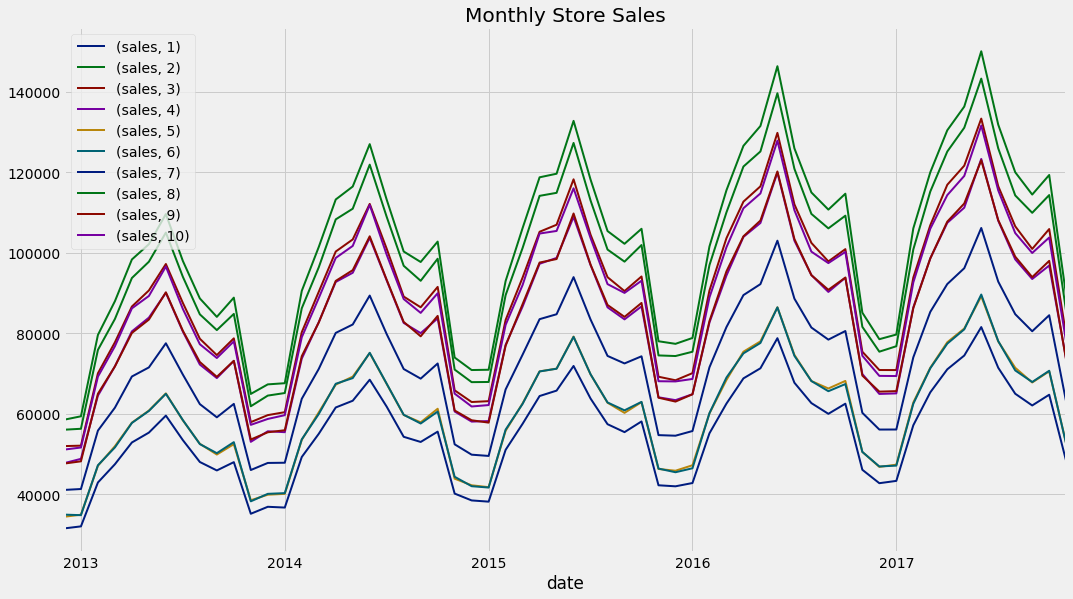

In [24]:
edaPlot(dataTrain, 'Monthly')

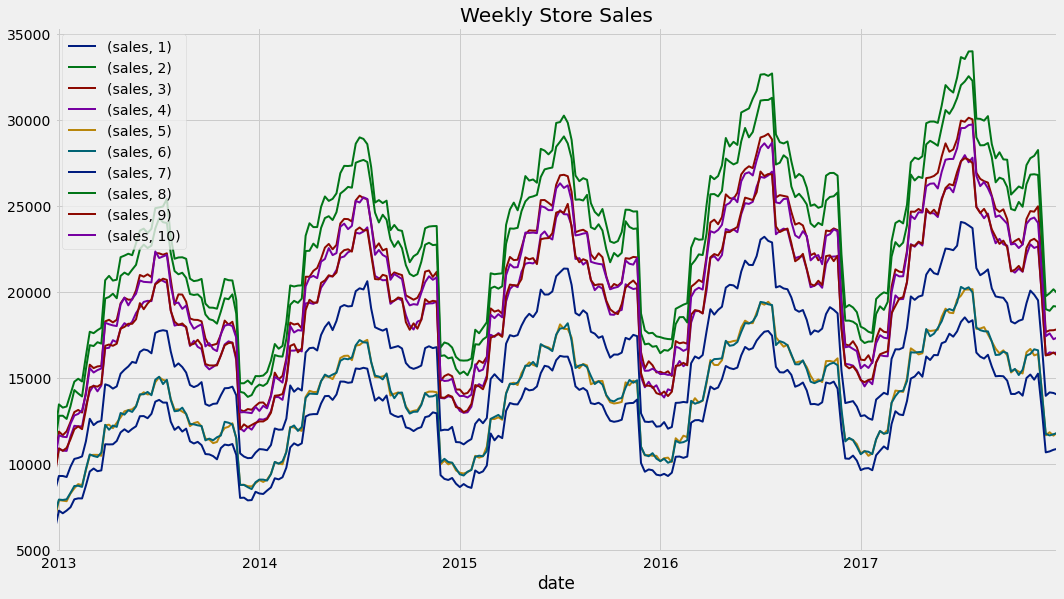

In [25]:
edaPlot(dataTrain, 'Weekly')

As observed in the graphs, we notice a pattern in the sales of the stores and a seasonality, premise that will be investigated with the plotting of ACF and PACF

- As we have a pattern among store sales, we will choose one randomly to verify the hypothesis of being stationary through the "adfullerTest" function, which was developed in the arima module

In [26]:
print(inspect.getdoc(adfullerTest))

Return the evidence against the null hypothesis(Ho) for analysis of the stacinonary of the series using the Dickey-Fuller test


Paramaters
----------
timeseries: Pandas Series in which the hypothesis test is to be performed
cutoff: Critical Value (Default -> 0.01)

Returns
-------
Text (Print) to be interpreted


In [27]:
store = np.random.randint(1, len(dataTrain.reset_index()['store'].unique()) + 1, 1)[0]
item = np.random.randint(1, len(dataTrain.reset_index()['item'].unique()) + 1, 1)[0]
print(f' store {store} -> item {item}')
adfullerTest(dataTrain[(dataTrain['store']==store) & (dataTrain['item']==item)]['sales'])

 store 6 -> item 28
ADF Test Statistic : -3.1315861275222776
p-value : 0.024302275618196194
#Lags Used : 23
Number of Observations Used : 1802
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


> according to the hypothesis test the Series is **non-stationary**

# Plot the original data and the respective rolling statistics

In [28]:
print(inspect.getdoc(rollingStatsPlot))

Plot y versus x as lines of the original data and the respective rolling statistics

y: Timeseries Values
X: Time

Paramaters
----------
timeseries: Pandas Series to be plotted 
window: Window for rolling statistics (Default -> 12)

Returns
-------
Plot


 store 2 -> item 5 



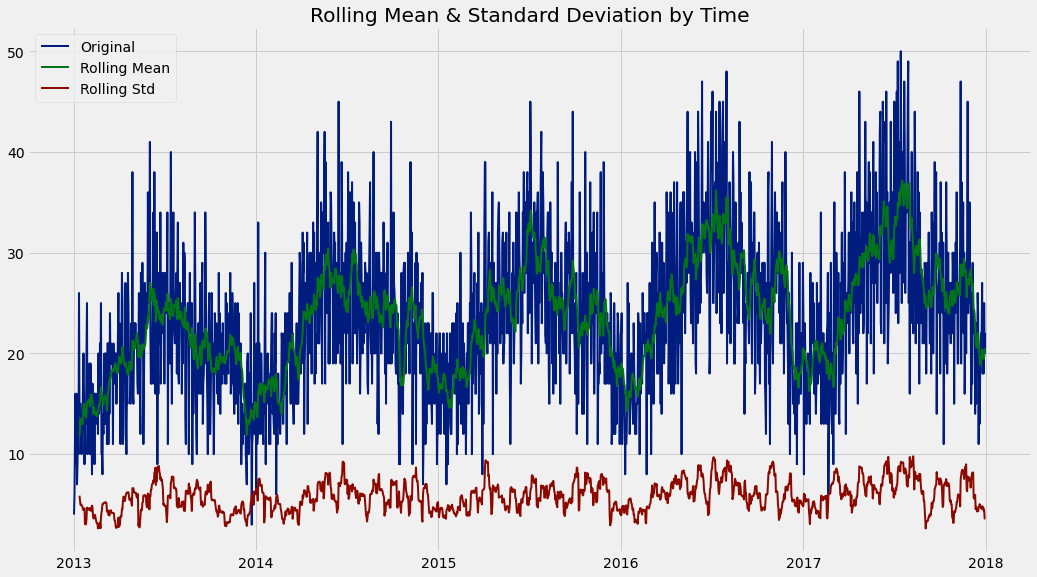

In [33]:
store = np.random.randint(1, len(dataTrain.reset_index()['store'].unique()) + 1, 1)[0]
item = np.random.randint(1, len(dataTrain.reset_index()['item'].unique()) + 1, 1)[0]

itemRandom = dataTrain[(dataTrain['store']==store) & (dataTrain['item']==item)]
print(f' store {store} -> item {item} \n')
rollingStatsPlot(itemRandom['sales'])

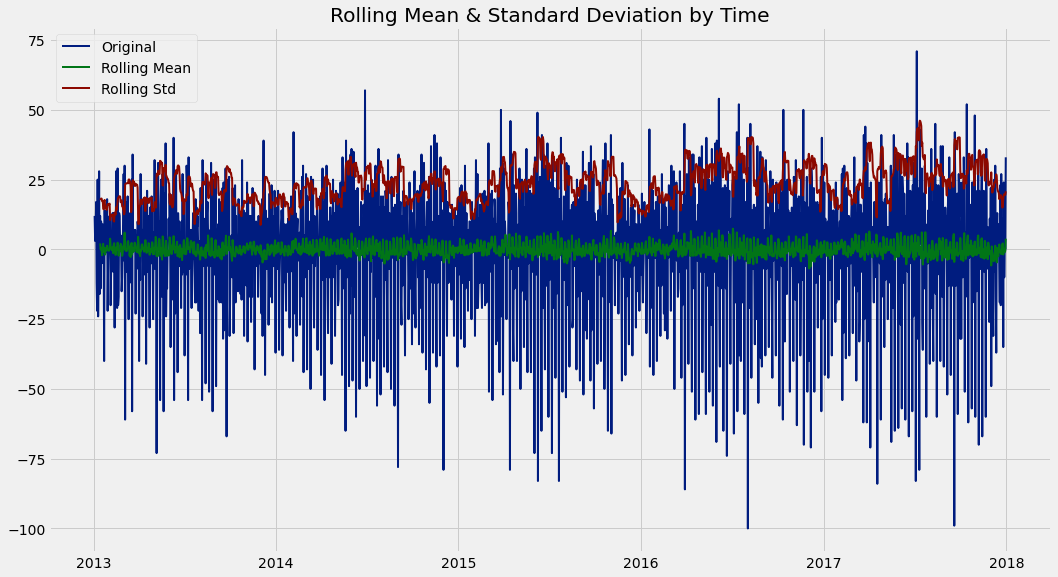

In [34]:
store = np.random.randint(1, len(dataTrain.reset_index()['store'].unique()) + 1, 1)[0]
item = np.random.randint(1, len(dataTrain.reset_index()['item'].unique()) + 1, 1)[0]

itemRandom = dataTrain[(dataTrain['store']==store) & (dataTrain['item']==item)]
itemRandom['lag_1_period'] = itemRandom['sales'].diff().shift()
itemRandom.dropna(inplace=True)
rollingStatsPlot(itemRandom['lag_1_period'])

In [31]:
adfullerTest(item_random['lag_1_period'])

ADF Test Statistic : -11.393090907952645
p-value : 7.979006235060106e-21
#Lags Used : 22
Number of Observations Used : 1801
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


# Plot ACF and PACF

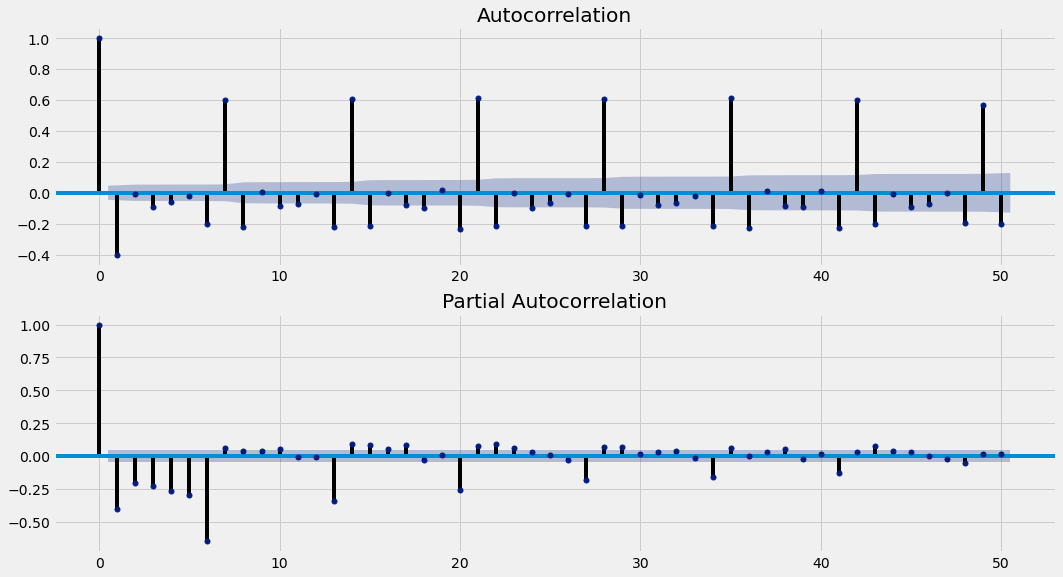

In [42]:
with plt.style.context('seaborn-dark-palette'):
    fig, ax = plt.subplots(2, figsize=(16,9))
    ax[0] = sm.graphics.tsa.plot_acf(itemRandom['lag_1_period'], lags=50, ax=ax[0])
    ax[1] = sm.graphics.tsa.plot_pacf(itemRandom['lag_1_period'], lags=50, ax=ax[1])

Both the ACF and the PACF plotted reveal a pattern of recurrence with period 7, which intensifies the initial premise that there is seasonality in the serious under analysis, so we can the SARIMA model has a better approach than the ARIMA model

In [36]:
#Arima Example AR:6 I:1 MA:0
arimaMod = sm.tsa.ARIMA(itemRandom.sales, (6,1,0)).fit(disp=False)
print(arimaMod.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1823
Model:                 ARIMA(6, 1, 0)   Log Likelihood               -7454.001
Method:                       css-mle   S.D. of innovations             14.421
Date:                Wed, 02 Dec 2020   AIC                          14924.002
Time:                        15:36:29   BIC                          14968.068
Sample:                    01-04-2013   HQIC                         14940.258
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0151      0.060      0.251      0.802      -0.103       0.133
ar.L1.D.sales    -0.8635      0.018    -48.599      0.000      -0.898      -0.829
ar.L2.D.sales    -0.7950      0.021    -

In [39]:
#Sarima Example AR:6 I:1 MA:1
sarima = sm.tsa.statespace.SARIMAX(itemRandom['sales'], trend='n', freq='D', enforce_invertibility=False,
                                   order=(6, 1, 1), seasonal_order=(1, 1, 1, 7))
results = sarima.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             sales   No. Observations:                 1824
Model:             SARIMAX(6, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -7089.456
Date:                           Wed, 02 Dec 2020   AIC                          14198.912
Time:                                   16:01:44   BIC                          14253.956
Sample:                               01-03-2013   HQIC                         14219.222
                                    - 12-31-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3615      0.320     -1.130      0.259      -0.989       0.266
ar.L2         -0.3312      0.250     -1.326

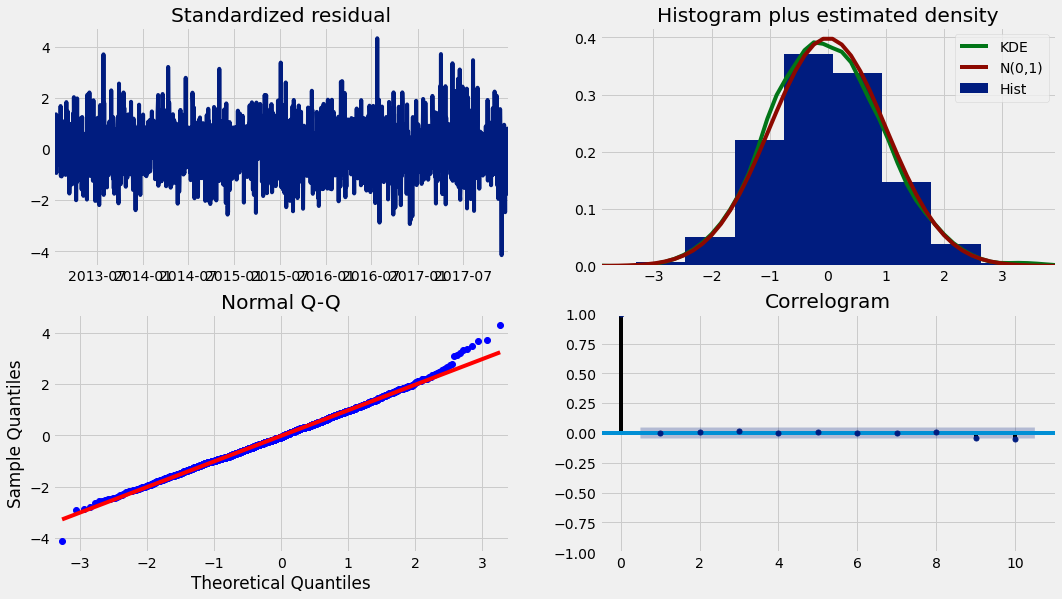

In [77]:
with plt.style.context('seaborn-dark-palette'):
    fig = results.plot_diagnostics(figsize=(16,9))

In [55]:
dataTest = pd.read_csv('../01-Data/test.csv', parse_dates=['date'], index_col='date')
sarimaResults = dataTest
sarimaResults['sales'] = 0

In [57]:
tic = time.time()

for s in sarima_results['store'].unique():
    for i in sarima_results['item'].unique():
        si = dataTrain.loc[(dataTrain['store'] == s) & (dataTrain['item'] == i), 'sales']
        sarima = sm.tsa.statespace.SARIMAX(si, trend='n', freq='D', enforce_invertibility=False,
                                           order=(6, 1, 1), seasonal_order=(1, 1, 1, 7))
        results = sarima.fit()
        fcst = results.predict(start='2018-01-01', end='2018-03-31', dynamic=True)
        sarima_results.loc[(sarimaResults['store'] == s) & (sarimaResults['item'] == i), 'sales'] = fcst.values
        
        toc = time.time()
        if i % 10 == 0:
            print("Completed store {} item {}. Cumulative time: {:.1f}s".format(s, i, toc-tic))

Completed store 1 item 10. Cumulative time: 76.9s
Completed store 1 item 20. Cumulative time: 149.4s
Completed store 1 item 30. Cumulative time: 223.3s
Completed store 1 item 40. Cumulative time: 297.4s
Completed store 1 item 50. Cumulative time: 374.2s
Completed store 2 item 10. Cumulative time: 444.5s
Completed store 2 item 20. Cumulative time: 531.6s
Completed store 2 item 30. Cumulative time: 618.0s
Completed store 2 item 40. Cumulative time: 694.9s
Completed store 2 item 50. Cumulative time: 763.2s
Completed store 3 item 10. Cumulative time: 838.7s
Completed store 3 item 20. Cumulative time: 917.8s
Completed store 3 item 30. Cumulative time: 998.8s
Completed store 3 item 40. Cumulative time: 1071.6s
Completed store 3 item 50. Cumulative time: 1150.5s
Completed store 4 item 10. Cumulative time: 1227.9s
Completed store 4 item 20. Cumulative time: 1300.4s
Completed store 4 item 30. Cumulative time: 1383.2s
Completed store 4 item 40. Cumulative time: 1464.8s
Completed store 4 item 50.

In [74]:
sarimaResults.reset_index(drop=True, inplace=True)
sarimaResults.drop(['store', 'item'], axis=1, inplace=True)
sarimaResults.head()

,id,sales
0,0,12.436930
1,1,15.124277
2,2,15.749127
3,3,16.827984
4,4,17.949967


# Plot an Example of the Forecast

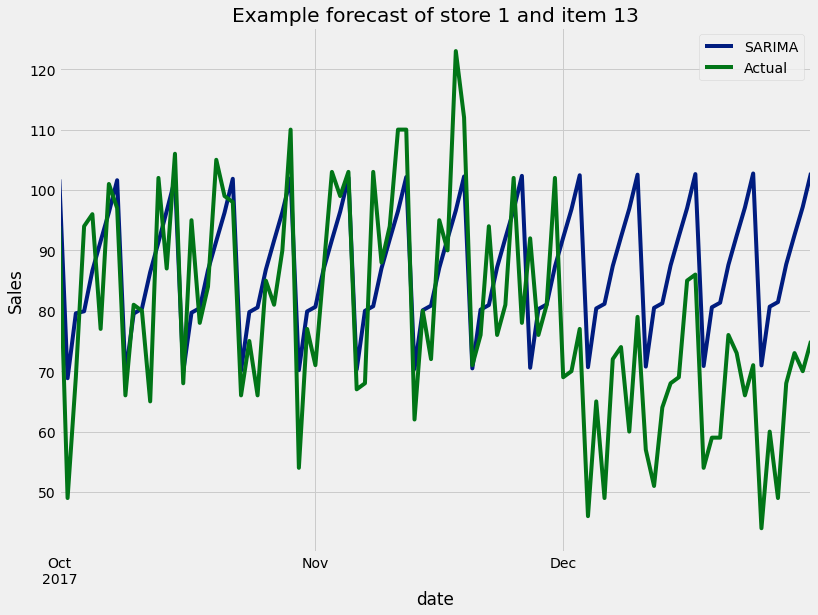

In [82]:
store = np.random.randint(1, len(dataTrain.reset_index()['store'].unique()) + 1, 1)[0]
item = np.random.randint(1, len(dataTrain.reset_index()['item'].unique()) + 1, 1)[0]

forecast = results.predict(start='2017-10-01', end='2017-12-31', dynamic=True)
actual = dataTrain.loc[(dataTrain['store'] == store) & (dataTrain['item'] == item), 'sales']

with plt.style.context('seaborn-dark-palette'):
    forecast.plot(figsize=(12,9))
    actual.loc['2017-10-01':].plot()
    plt.legend(['SARIMA', 'Actual'])
    plt.ylabel('Sales');
    plt.title(f'Example forecast of store {store} and item {item}')

# SMAPE Score

In [84]:
## Random Example
smape(actual, forecast)

16.655873821109363

# Convert to .csv

In [75]:
sarimaResults.to_csv('../Results/baselineSarimaResults.csv', index=False)